In [ ]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim import corpora, models, similarities
import numpy as np
from wordcloud import WordCloud
np.random.seed(2020)

import nltk
nltk.download('wordnet')  #Natural Language Toolkit : boîte-à-outil permettant la création de programmes pour l'analyse de texte

stemmer = SnowballStemmer('english') #Create a new instance of a language specific subclass

import sklearn
from sklearn.metrics import pairwise_distances
import hdbscan
import seaborn as sns

from gensim.models import word2vec
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df=pd.read_csv('C:\\Users\\Admin\\Documents\\Big Data & marketing\\archive\\winemag-data_first150k.csv')
df2=df['description']
df2=df2.sample(n=30000)

In [ ]:
#List comprehension
processed_description = [[stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in simple_preprocess(description) if token not in STOPWORDS] for description in df2]

## CLUSTERING

### HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) : is a clustering algorithm 

Here, there is no assumptions except for some noise. HDBSCAN uses a density-based approach and it's a non-parametric method that looks for a cluster hierarchy shaped.  Rather than looking for clusters with a particular shape, it looks for regions of the data that are denser than the surrounding space.

The underlying distribution is almost always unknown for real-world data estimate the PDF.

2 ways : 
- Counting the number of neighbors of a particular point within its 𝜀-radius (hypersphere around the point and count the number of points within it)
- Finding the distance to the K-th nearest neighbor. We determine the number of neighbors we want and find the smallest value of 𝜀 that would contain these K neighbors. Which is what HDBSCAN uses.

This distances are called 'core' distances in HDBSCAN. Points with smaller core distances are in denser regions and would have a high estimate for the PDF. Points with larger core distances are in sparser regions because we have to travel larger distances to include enough neighbors. 

The hyperparameter K is referred to as min_samples in the HDBSCAN. If K is too low then we have lots of noise. If K is too high it smoothen the PDF too much. The larger the value of min_samples you provide, the more conservative the clustering – more points will be declared as noise. 


Important to use min_cluster_size. Distribution graphs may show peaks and bumps. min_cluster_size dictates the maximum size of a “bump” before it is considered a peak. An issue can appear if little bumps are interpreted as mini-clusters. Without removing the bumps, the main clusters may not be seen. The solution is to flatten these small bumps. Main clusters will no longer be distracted by the small bumps

First step is to vectorize words so that they can be represented in a graph

### First do Word2Vec

In [ ]:
model = word2vec.Word2Vec(processed_description, size=300, window=20, min_count=2, workers=1, iter=100)

In [ ]:
# 10 first vectors coordinates associated to the word 'banana'
model.wv['banana'][:10]

array([-1.9126035 , -3.7639444 ,  2.6916788 , -1.628046  , -0.20538172,
       -2.874452  , -1.54879   ,  0.40231127, -3.0689895 ,  0.08890978],
      dtype=float32)

In [ ]:
w2v_vectors = model.wv.vectors

In [ ]:
w2v_indices = {word: model.wv.vocab[word].index for word in model.wv.vocab} # here you load indices - with whom you can find an index of the particular word in your model 

### Use the hierarchical density-based clustering method


In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 5, min_samples = 10, gen_min_span_tree=True, cluster_selection_method = 'leaf')
clusterer.fit(w2v_vectors)

C:\Users\Admin\anaconda3\envs\PythonCPU\lib\site-packages\hdbscan\hdbscan_.py:219: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)


HDBSCAN(cluster_selection_method='leaf', gen_min_span_tree=True, min_samples=10)

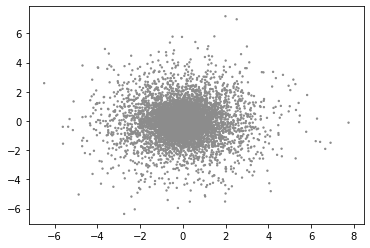

In [ ]:
pal = sns.color_palette('deep', 8)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,
                                                           clusterer.probabilities_)]
plt.scatter(w2v_vectors.T[0], w2v_vectors.T[1], c=colors, s=1.8)

<AxesSubplot:ylabel='$\\lambda$ value'>

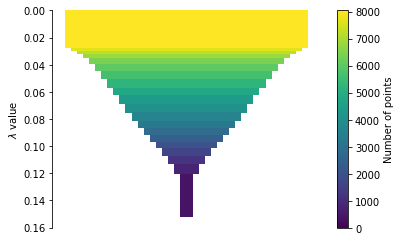

In [ ]:
clusterer.condensed_tree_.plot()

As we can see the clustering is not very relevant, as it can not clearly identify clusters based on the density.

## Marketing insights

These kind of analysis on reviews can provide some leads from a marketing standpoint. First, we can consider an online wine shop that uses the magazine’s reviews in order to analyse its market and target clients. By doing clusters the goal is to use client’s preferences to do personalized suggestions. 

Given the client’s favourite wines or his activity on the website, the online shop could target its ads, its email campaign and even the order in which the products are displayed, depending on the cluster in which the customer's favourite wine is or the wine he clicked on. 

For instance, the first TF-IDF cluster probably groups white wines, some chardonnay grape variety, some dry white wine and with a predominance of a citrus and peach aroma, if a client really likes a wine with chardonnay grape variety or citrus aroma, the website could suggest wines that share similarities. 

To conclude, there are advantages and disadvantages in each method. In clustering method groups can be too big and in LDA only half are relevant. Unlike Clustering method, LDA is a probabilistic method but needs more computational power. LDA needs a large volume of data whereas clustering does not. LDA does not keep sentence structure, Clustering is sensitive to corpus and it is hard to name topics unlike LDA method. 

Moreover, in LDA we need to create and combine a dictionary for english and for french if have 2 languages which is hard to do. Finally, we think that we could refine our stopword list since we saw recurrent wine vocabulary in each subgroup.